In [1]:
%ls

data/                         new_dataset.py  results/
denoising_diffusion_pytorch/  __pycache__/    train.ipynb


In [2]:
from new_dataset import *

data = DatasetSVD('Cifar-10') # cifar10
images, labels = data.get_svd()
custom_dataset = CustomDataset(images, labels)


/home/Chaehyun/anaconda3/envs/0225_ddpm/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Files already downloaded and verified


100%|██████████| 50000/50000 [00:43<00:00, 1138.70it/s]


In [3]:
len(custom_dataset)

50000

https://github.com/lucidrains/denoising-diffusion-pytorch

In [5]:
from denoising_diffusion_pytorch import Unet, GaussianDiffusion, Trainer

In [6]:
model = Unet(
    dim = 64,
    dim_mults = (1, 2, 4, 8),
    flash_attn = True
)

diffusion = GaussianDiffusion(
    model,
    image_size = 32, # 이미지 사이즈 맞춰서 
    timesteps = 1000    # number of steps
)

Non-A100 GPU detected, using math or mem efficient attention if input tensor is on cuda


In [8]:
trainer = Trainer(
diffusion,
custom_dataset,
train_batch_size = 32,
train_lr = 8e-5,
train_num_steps = 1000,         # total training steps 700000
gradient_accumulate_every = 2,    # gradient accumulation steps
ema_decay = 0.995,                # exponential moving average decay
amp = True,                       # turn on mixed precision
calculate_fid = True              # whether to calculate fid during training
)

In [ ]:
class Trainer(object):
    def __init__(
        self,
        diffusion_model,
        folder = "dataloader",
        *,
        train_batch_size = 16,
        gradient_accumulate_every = 1,
        augment_horizontal_flip = True,
        train_lr = 1e-4,
        train_num_steps = 100000,
        ema_update_every = 10,
        ema_decay = 0.995,
        adam_betas = (0.9, 0.99),
        save_and_sample_every = 1000,
        num_samples = 25,
        results_folder = './results',
        amp = False,
        mixed_precision_type = 'fp16',
        split_batches = True,
        convert_image_to = None,
        calculate_fid = True,
        inception_block_idx = 2048,
        max_grad_norm = 1.,
        num_fid_samples = 50000,
        save_best_and_latest_only = False
    ):
        super().__init__()

        # accelerator

        self.accelerator = Accelerator(
            split_batches = split_batches,
            mixed_precision = mixed_precision_type if amp else 'no'
        )

        # model

        self.model = diffusion_model
        self.channels = diffusion_model.channels
        is_ddim_sampling = diffusion_model.is_ddim_sampling

        # default convert_image_to depending on channels

        if not exists(convert_image_to):
            convert_image_to = {1: 'L', 3: 'RGB', 4: 'RGBA'}.get(self.channels)

        # sampling and training hyperparameters

        assert has_int_squareroot(num_samples), 'number of samples must have an integer square root'
        self.num_samples = num_samples
        self.save_and_sample_every = save_and_sample_every

        self.batch_size = train_batch_size
        self.gradient_accumulate_every = gradient_accumulate_every
        assert (train_batch_size * gradient_accumulate_every) >= 16, f'your effective batch size (train_batch_size x gradient_accumulate_every) should be at least 16 or above'

        self.train_num_steps = train_num_steps
        self.image_size = diffusion_model.image_size

        self.max_grad_norm = max_grad_norm

        # dataset and dataloader

        #self.ds = Dataset(folder, self.image_size, augment_horizontal_flip = augment_horizontal_flip, convert_image_to = convert_image_to)
        self.ds = folder
        assert len(self.ds) >= 100, 'you should have at least 100 images in your folder. at least 10k images recommended'

        dl = DataLoader(self.ds, batch_size = train_batch_size, shuffle = True, pin_memory = True, num_workers = cpu_count())

        dl = self.accelerator.prepare(dl)
        self.dl = cycle(dl)

        # optimizer

        self.opt = Adam(diffusion_model.parameters(), lr = train_lr, betas = adam_betas)

        # for logging results in a folder periodically

        if self.accelerator.is_main_process:
            self.ema = EMA(diffusion_model, beta = ema_decay, update_every = ema_update_every)
            self.ema.to(self.device)

        self.results_folder = Path(results_folder)
        self.results_folder.mkdir(exist_ok = True)

        # step counter state

        self.step = 0

        # prepare model, dataloader, optimizer with accelerator

        self.model, self.opt = self.accelerator.prepare(self.model, self.opt)

        # FID-score computation

        self.calculate_fid = calculate_fid and self.accelerator.is_main_process

        if self.calculate_fid:
            if not is_ddim_sampling:
                self.accelerator.print(
                    "WARNING: Robust FID computation requires a lot of generated samples and can therefore be very time consuming."\
                    "Consider using DDIM sampling to save time."
                )
            self.fid_scorer = FIDEvaluation(
                batch_size=self.batch_size,
                dl=self.dl,
                sampler=self.ema.ema_model,
                channels=self.channels,
                accelerator=self.accelerator,
                stats_dir=results_folder,
                device=self.device,
                num_fid_samples=num_fid_samples,
                inception_block_idx=inception_block_idx
            )

        if save_best_and_latest_only:
            assert calculate_fid, "`calculate_fid` must be True to provide a means for model evaluation for `save_best_and_latest_only`."
            self.best_fid = 1e10 # infinite

        self.save_best_and_latest_only = save_best_and_latest_only

    @property
    def device(self):
        return self.accelerator.device

    def save(self, milestone):
        if not self.accelerator.is_local_main_process:
            return

        data = {
            'step': self.step,
            'model': self.accelerator.get_state_dict(self.model),
            'opt': self.opt.state_dict(),
            'ema': self.ema.state_dict(),
            'scaler': self.accelerator.scaler.state_dict() if exists(self.accelerator.scaler) else None,
            'version': __version__
        }

        torch.save(data, str(self.results_folder / f'model-{milestone}.pt'))

    def load(self, milestone):
        accelerator = self.accelerator
        device = accelerator.device

        data = torch.load(str(self.results_folder / f'model-{milestone}.pt'), map_location=device)

        model = self.accelerator.unwrap_model(self.model)
        model.load_state_dict(data['model'])

        self.step = data['step']
        self.opt.load_state_dict(data['opt'])
        if self.accelerator.is_main_process:
            self.ema.load_state_dict(data["ema"])

        if 'version' in data:
            print(f"loading from version {data['version']}")

        if exists(self.accelerator.scaler) and exists(data['scaler']):
            self.accelerator.scaler.load_state_dict(data['scaler'])

    def train(self):
        accelerator = self.accelerator
        device = accelerator.device

        with tqdm(initial = self.step, total = self.train_num_steps, disable = not accelerator.is_main_process) as pbar:

            while self.step < self.train_num_steps:

                total_loss = 0.

                for _ in range(self.gradient_accumulate_every):
                    data = next(self.dl)[0].to(device)

                    with self.accelerator.autocast():
                        loss = self.model(data)
                        loss = loss / self.gradient_accumulate_every
                        total_loss += loss.item()

                    self.accelerator.backward(loss)

                pbar.set_description(f'loss: {total_loss:.4f}')

                accelerator.wait_for_everyone()
                accelerator.clip_grad_norm_(self.model.parameters(), self.max_grad_norm)

                self.opt.step()
                self.opt.zero_grad()

                accelerator.wait_for_everyone()

                self.step += 1
                if accelerator.is_main_process:
                    self.ema.update()

                    if self.step != 0 and divisible_by(self.step, self.save_and_sample_every):
                        self.ema.ema_model.eval()

                        with torch.inference_mode():
                            milestone = self.step // self.save_and_sample_every
                            batches = num_to_groups(self.num_samples, self.batch_size)
                            all_images_list = list(map(lambda n: self.ema.ema_model.sample(batch_size=n), batches))

                        all_images = torch.cat(all_images_list, dim = 0)

                        utils.save_image(all_images, str(self.results_folder / f'sample-{milestone}.png'), nrow = int(math.sqrt(self.num_samples)))

                        # whether to calculate fid

                        if self.calculate_fid:
                            fid_score = self.fid_scorer.fid_score()
                            accelerator.print(f'fid_score: {fid_score}')
                        if self.save_best_and_latest_only:
                            if self.best_fid > fid_score:
                                self.best_fid = fid_score
                                self.save("best")
                            self.save("latest")
                        else:
                            self.save(milestone)

                pbar.update(1)

        accelerator.print('training complete')

In [9]:
trainer.train()


sampling loop time step: 100%|██████████| 1000/1000 [00:14<00:00, 70.73it/s]


Stacking Inception features for 50000 samples from the real dataset.


loss: 0.0464: 100%|█████████▉| 999/1000 [53:49<00:03,  3.23s/it]


TypeError: 'DataLoaderShard' object is not an iterator

In [10]:
sampled_images = diffusion.sample(batch_size = 4)

sampling loop time step: 100%|██████████| 1000/1000 [00:11<00:00, 84.11it/s]


In [11]:
sampled_images.shape

torch.Size([4, 3, 32, 32])

In [12]:
import matplotlib.pyplot as plt

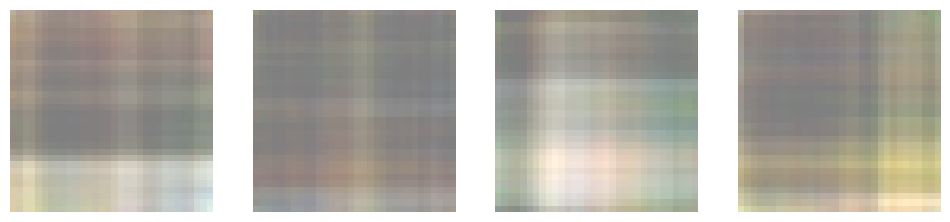

In [13]:
def visualize_images(sampled_image):
    # 이미지를 [0, 1] 범위로 정규화
    sampled_image = sampled_image / 2 + 0.5
    # 이미지를 numpy 배열로 변환
    sampled_image = sampled_image.cpu().numpy()
    # 이미지를 (배치 크기, 채널, 높이, 너비)에서 (배치 크기, 높이, 너비, 채널)로 변환
    sampled_image = np.transpose(sampled_image, (0, 2, 3, 1))

    # 이미지 플로팅
    num_images = sampled_image.shape[0]
    fig, axes = plt.subplots(1, num_images, figsize=(num_images * 3, 3))
    for i in range(num_images):
        axes[i].imshow(sampled_image[i])
        axes[i].axis('off')
    plt.show()

# sampled_image는 텐서입니다.
visualize_images(sampled_images)

## fid score 구현

In [1]:
!pwd

/home/Chaehyun/0225_code/git_file


In [15]:
!pip install diffusers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.9/40.9 kB 2.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 11.1 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 789.1/789.1 kB 10.8 MB/s eta 0:00:0000:0100:01


In [2]:
%ls

data/                         new_dataset.py  results/
denoising_diffusion_pytorch/  __pycache__/    train.ipynb


In [3]:
from new_dataset import *

data = DatasetSVD('Cifar-10') # cifar10
images, labels = data.get_svd()

/home/Chaehyun/anaconda3/envs/0225_ddpm/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/Chaehyun/anaconda3/envs/0225_ddpm/lib/python3.12/site-packages/diffusers/utils/outputs.py:63: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  torch.utils._pytree._register_pytree_node(
/home/Chaehyun/anaconda3/envs/0225_ddpm/lib/python3.12/site-packages/diffusers/utils/outputs.py:63: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  torch.utils._pytree._register_pytree_node(


Files already downloaded and verified


100%|██████████| 50000/50000 [00:44<00:00, 1114.29it/s]


In [4]:
custom_dataset_ae = CustomDataset(images, labels, True)

In [5]:
len(custom_dataset_ae)

50000

In [17]:
from torch.utils.data import DataLoader
dataloader = DataLoader(custom_dataset, batch_size=32, shuffle=True) #, drop_last=True